# Predictive Modeling

## Introduction

This predictive modeling is part of the development of a pricing strategy for a short-term rental platform. Based on the exploratory data analysis ([EDA](EDA.ipynb)) performed previously, significant patterns and relationships were identified between several variables that influence the price of properties.

This notebook aims to build and evaluate predictive models that can help determine prices for listings in New York City. To this end, machine learning techniques will be used to predict rental prices based on characteristics such as location, property type, availability, and guest reviews. The modeling will be performed using the Pandas, Numpy, Scikit-Learn, and TensorFlow libraries, as well as some auxiliary libraries.

### Solution Approach

The main objective of this problem is to predict the price of a property, a numerical variable, characterizing it as a regression problem. The approach adopted to solve it will be the following:

1. Understanding the Problem
    * Main Objective: Predict the price of a property advertised on a temporary rental platform in New York City.
    * Problem Type: Regression, since the target variable price is numerical in nature.
    * Chosen Metrics:
        * Mean Absolute Error (MAE): Easy to interpret, since it is in the same unit as the target variable and is not sensitive to outliers.
        * Coefficient of Determination (R²): Measures how much the model explains the target variable. It varies from $(-\infty, 1)$, where negative values ​​indicate that the model is worse than simply using the mean, while 1 indicates that the model perfectly explains the data.
        * Root Mean Square Error (RMSE): Penalizes larger errors, useful for providing an overview of the model's performance.

2. Data Preparation
    * Variable Selection: Based on exploratory data analysis (EDA), choosing the most relevant attributes for pricing.
    * Data Cleaning:
    * Treatment of missing values;
    * Correction of inconsistencies;
    * Removal of outliers.
    * Data Splitting: Separation into training and test sets.
    * Standardization: Application of scaling to normalize the data.

3. Model Selection and Training
    * Selected Models:
        * LightGBM: Fast and efficient, with good generalization capacity.
        * XGBoost: Offers built-in regularization, helping to avoid overfitting.
        * Gradient Boosting: Less sensitive to outliers, although a little slower.
        * Random Forest: Works well on tabular data and handles noise better.
        * Logistic Regression: Simple and interpretable.
        * Neural Networks: Offer greater flexibility and complex modeling capability.
        * KNN: It offers simplicity, and takes advantage of the geographic properties contained in the dataset.
    * Cross-Validation: Use of the K-Fold method to evaluate model performance.

4. Evaluation and Adjustment of the Best Model
    * Hyperparameter Optimization: Use of GridSearchCV to find the best configuration of the selected model.
    * Final Test: Application of the trained model on the test set (X_test) for final performance evaluation.

## Data Preparation

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import tensorflow as tf
import warnings
import joblib
 
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

warnings.filterwarnings("ignore", category=FutureWarning)

### Loading the dataset

In [2]:
dataset = pd.read_csv('Data/teste_indicium_precificacao.csv')

dataset.drop(columns=['id','host_id','host_name','ultima_review','reviews_por_mes','bairro','nome','calculado_host_listings_count'], inplace=True)
dataset.head()

room_types = dataset['room_type'].unique()
bairro_groups = dataset['bairro_group'].unique()

### Handling Missing Data

Checking for missing data is not a trivial task. Columns can often be filled with default or inconsistent values, making it difficult to identify missing information. The presence of missing data can compromise the quality of the analysis and the performance of predictive models, leading to erroneous conclusions or inaccurate predictions.

In this section, we will focus on identifying and resolving the inconsistencies found in the `price` and `disponibilidade_365` variables. These variables are critical for modeling, since price is the target variable we want to predict, and availability reflects the affordability of the property throughout the year.

In [3]:
dataset[(dataset['price'] == 0)].shape , dataset[(dataset['disponibilidade_365'] == 0)].shape

((11, 8), (17533, 8))

<Axes: ylabel='disponibilidade_365'>

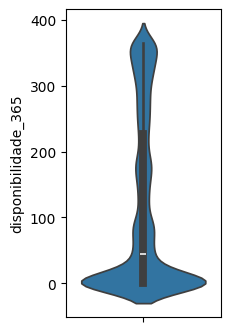

In [4]:
fig, ax = plt.subplots(figsize=(2,4))
sns.violinplot(data=dataset, y='disponibilidade_365', ax=ax)

Based on EDA, we identified zero values ​​in `price` and `disponibilidade_365`, which do not match the nature of these variables and are considered inconsistent. There are more than 17 thousand occurrences in `disponibilidade_365` and 11 in price. As shown in the graph, these values ​​distort the distribution of `disponibilidade_365`.

To correct this, we will use the KNN algorithm, which will estimate the missing values ​​based on the average of 5 neighbors. The imputation will be done considering the geographic variables `latitude` and `longitude`, in addition to `room_type`.

In [5]:
# Selecionando as colunas necessárias e substituindo valores 0 por NaN na coluna 'price'
df_filtered = pd.concat((dataset[['latitude', 'longitude','price']], pd.get_dummies(dataset['room_type'], dtype=int)), axis=1).copy()
df_filtered['price'] = df_filtered['price'].replace(0, np.nan)

# Normalização dos dados
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df_filtered)

# Imputação dos valores ausentes
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(scaled_data)

# Revertendo a normalização para os valores originais
df_imputed = pd.DataFrame(scaler.inverse_transform(imputed_data), columns=df_filtered.columns)

# Atualizando a coluna 'price' no DataFrame original
dataset['price'] = df_imputed['price'].round().astype(int)

In [6]:
# Selecionando as colunas necessárias e substituindo valores 0 por NaN na coluna 'price'
df_filtered = pd.concat((dataset[['latitude', 'longitude','disponibilidade_365']], pd.get_dummies(dataset['room_type'], dtype=int)), axis=1).copy()
df_filtered['disponibilidade_365'] = df_filtered['disponibilidade_365'].replace(0, np.nan)

# Normalização dos dados
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df_filtered)

# Imputação dos valores ausentes
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(scaled_data)

# Revertendo a normalização para os valores originais
df_imputed = pd.DataFrame(scaler.inverse_transform(imputed_data), columns=df_filtered.columns)

# Atualizando a coluna disponibilidade_365 no DataFrame original
dataset['disponibilidade_365'] = df_imputed['disponibilidade_365'].round().astype(int)

To preserve the original dataset, the padded values ​​were calculated separately and then incorporated into the dataset.

<Axes: ylabel='disponibilidade_365'>

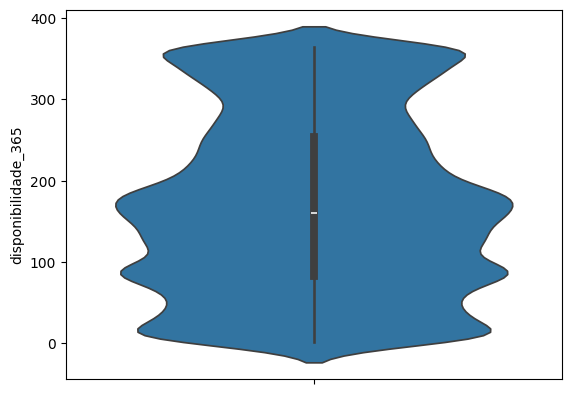

In [7]:
sns.violinplot(data=dataset, y='disponibilidade_365')

After imputation with KNN, the corrected values ​​were incorporated into the original set, ensuring greater consistency in the data. In the updated graph, the distribution of `disponibilidade_365` became more balanced, without the distortion of zero values. Most properties have availability at intermediate levels, making the data more representative for the model.

### Outlier Removal

One challenge in removing outliers is the large variation between different types of variables. For example, prices in 'Manhattan' for 'Entire home/apt' are very different from those for 'Shared room'. In addition, many outliers correspond to properties with unique characteristics that stand out from the rest of the data.

In this step, outliers for the `price` variable were removed using `room_type` and `bairro_group` as filters, since combining these variables results in distinct price distributions. Removal was done using Tukey's method, which sets thresholds based on the 25% and 75% quantiles.

<Axes: xlabel='bairro_group', ylabel='price'>

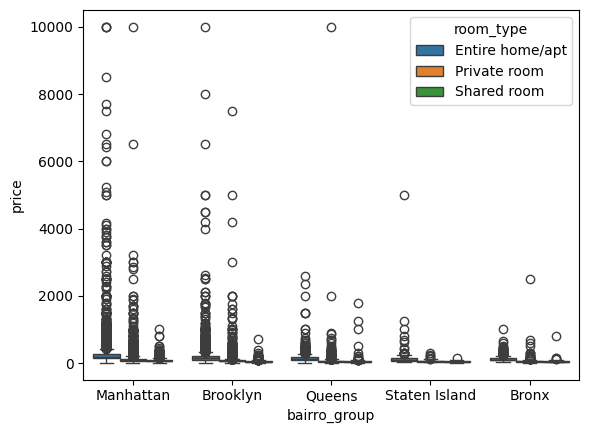

In [8]:
sns.boxplot(data=dataset, x='bairro_group', y='price',hue='room_type')

In [9]:
# Calculating quantiles for the `price` variable with `room_type` and `bairro_group`
q1_price = pd.pivot_table(data=dataset, values='price', index='bairro_group', columns='room_type', aggfunc=lambda x: x.quantile(0.25))
q3_price = pd.pivot_table(data=dataset, values='price', index='bairro_group', columns='room_type', aggfunc=lambda x: x.quantile(0.75))

# Calculating the interquartile range
iqr_price = q3_price - q1_price

# Calculating the lower and upper limits
inf_price = q1_price - (1.5 * iqr_price)
sup_price = q3_price + (1.5 * iqr_price)

In [10]:
# Function to filter `price` from calculated limits
def filter_price(row):
    if (row['price'] >= inf_price.loc[row['bairro_group'],row['room_type']]) and (row['price'] <= sup_price.loc[row['bairro_group'],row['room_type']]):
        return True
    else:
        return False

<Axes: xlabel='bairro_group', ylabel='price'>

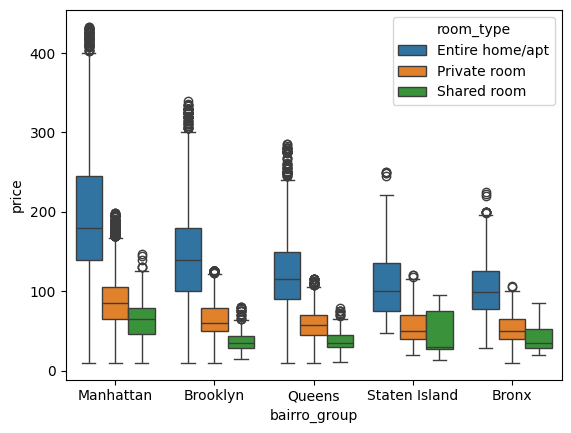

In [11]:
# Updating the dataset without the `price` outliers and plotting the new distribution
dataset = dataset[dataset.apply(filter_price, axis=1)].copy()
sns.boxplot(data=dataset, x='bairro_group', y='price', hue='room_type')

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45418 entries, 0 to 48893
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bairro_group         45418 non-null  object 
 1   latitude             45418 non-null  float64
 2   longitude            45418 non-null  float64
 3   room_type            45418 non-null  object 
 4   price                45418 non-null  int64  
 5   minimo_noites        45418 non-null  int64  
 6   numero_de_reviews    45418 non-null  int64  
 7   disponibilidade_365  45418 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 3.1+ MB


Removing outliers in `price` is essential, as it is the target variable, which helps models generalize better to common prices. However, to predict high-end real estate values, specific models would need to be developed.

### Data Type Conversion

To optimize memory usage and improve processing performance, the types of numeric columns have been adjusted. The variables `price`, `minimo_noites`, `numero_de_reviews` and `disponibilidade_365` have been converted to *uint16*, as their values ​​are positive integers and do not require more than 16 bits of storage. `latitude` and `longitude` have been converted to *float32*, reducing memory consumption without significant loss of precision. This conversion results in a more efficient dataset, without compromising data integrity.

In [13]:
dataset.describe().loc[['min', 'max']]

,latitude,longitude,price,minimo_noites,numero_de_reviews,disponibilidade_365
min,40.49979,-74.24442,10.0,1.0,0.0,1.0
max,40.91306,-73.71299,433.0,1250.0,629.0,365.0


In [14]:
dataset['price'] = dataset['price'].astype(np.uint16)
dataset['minimo_noites'] = dataset['minimo_noites'].astype(np.uint16)
dataset['numero_de_reviews'] = dataset['numero_de_reviews'].astype(np.uint16)
dataset['disponibilidade_365'] = dataset['disponibilidade_365'].astype(np.uint16)
dataset['latitude'] = dataset['latitude'].astype(np.float32)
dataset['longitude'] = dataset['longitude'].astype(np.float32)

In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45418 entries, 0 to 48893
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bairro_group         45418 non-null  object 
 1   latitude             45418 non-null  float32
 2   longitude            45418 non-null  float32
 3   room_type            45418 non-null  object 
 4   price                45418 non-null  uint16 
 5   minimo_noites        45418 non-null  uint16 
 6   numero_de_reviews    45418 non-null  uint16 
 7   disponibilidade_365  45418 non-null  uint16 
dtypes: float32(2), object(2), uint16(4)
memory usage: 1.7+ MB


## Feature Engineering

### Encoding Categorical Variables

The categorical variables `room_type` and `bairro_group` have been transformed into numeric variables using one-hot encoding. This method creates binary columns for each category, allowing models to interpret these variables correctly. In addition, the new attributes have been converted to *int* and *uint8* types, reducing memory consumption. The transformation facilitates the application of machine learning algorithms and does not introduce relationships between categories, as in the case of ordinal encoding.

In [16]:
dataset = pd.concat((dataset, pd.get_dummies(dataset['room_type'], dtype=np.uint8), 
                     pd.get_dummies(dataset['bairro_group'], dtype=np.uint8)), axis=1).drop(columns=['room_type','bairro_group'])

In [17]:
dataset.head()

,latitude,longitude,price,minimo_noites,numero_de_reviews,disponibilidade_365,Entire home/apt,Private room,Shared room,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,40.753620,-73.983772,225,1,45,355,1,0,0,0,0,1,0,0
1,40.809021,-73.941902,150,3,0,365,0,1,0,0,0,1,0,0
2,40.685139,-73.959763,89,1,270,194,1,0,0,0,1,0,0,0
3,40.798512,-73.943993,80,10,9,128,1,0,0,0,0,1,0,0
4,40.747669,-73.974998,200,3,74,129,1,0,0,0,0,1,0,0


In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45418 entries, 0 to 48893
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   latitude             45418 non-null  float32
 1   longitude            45418 non-null  float32
 2   price                45418 non-null  uint16 
 3   minimo_noites        45418 non-null  uint16 
 4   numero_de_reviews    45418 non-null  uint16 
 5   disponibilidade_365  45418 non-null  uint16 
 6   Entire home/apt      45418 non-null  uint8  
 7   Private room         45418 non-null  uint8  
 8   Shared room          45418 non-null  uint8  
 9   Bronx                45418 non-null  uint8  
 10  Brooklyn             45418 non-null  uint8  
 11  Manhattan            45418 non-null  uint8  
 12  Queens               45418 non-null  uint8  
 13  Staten Island        45418 non-null  uint8  
dtypes: float32(2), uint16(4), uint8(8)
memory usage: 1.4 MB


### Splitting the Data 

The data was split into training and testing sets. The variable `X` contains all the columns of the dataset, except `price`, which will be the target variable `y`. The *train_test_split* function separates 80% of the data for training and 20% for testing, ensuring reproducibility with *random_state=42*. This will allow the model to be evaluated on data that was not used for training, functioning as a generalization test.

In [19]:
X = dataset.drop(columns=['price']).values
y = dataset['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
(X_train.shape, X_test.shape)

((36334, 13), (9084, 13))

### Feature Scaling

The input data *X_train* and *X_test* were standardized using *StandardScaler*. This method transforms the data so that it has a mean of 0 and a standard deviation of 1, aiming to improve the performance of models, especially those that rely on distance-based calculations, such as logistic regression and neural networks. *fit_transform* is applied only to the training data, and *transform* is applied to the test data to avoid the famous data leakage.

In [21]:
scaler = sk.preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Saving the scaler for future predictions
joblib.dump(scaler, "Saved_Models/scaler.pkl")

['Saved_Models/scaler.pkl']

## Modeling

### Training and K-Fold Cross-Validation Function

For training, the K-Fold technique was used, which divides the data set into 5 equal parts to perform cross-validation. This approach allows the model to be trained and validated on different subsets of the data, ensuring a more robust evaluation and reducing the risk of overfitting. During the process, the data is separated into training and validation sets for each fold, and the model is trained and evaluated iteratively, with the metrics that were selected: RMSE, MAE and R2.

In [22]:
# Training and evaluation function of models
def evaluate_model(model, X, y, model_name, func_model=None, n_splits=5, random_state=42):
    # K-fold Initialization
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Creating a dictionary to save model evaluation results
    results = {
        "fold": [],
        "rmse": [],
        "mae": [],
        "r2": []
    }
    
    # Iteration and separation of folds
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"Fold {fold + 1}")
        
        # Separating data into training and validation
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Training and plotting statistics for the neural network
        if(model_name == 'Neural Network'):
            model = func_model()
            history = model.fit(X_train, y_train, epochs=200, batch_size=256, 
                                validation_data=(X_val, y_val), verbose=0)

            fig, ax = plt.subplots(1,2,figsize=(14, 4))
            ax[0].plot(history.history['loss'][30:], label='Train Loss')
            ax[0].plot(history.history['val_loss'][30:], label='Validation Loss')
            ax[1].plot(history.history['r2_score'][30:], label='Train r2_score')
            ax[1].plot(history.history['val_r2_score'][30:], label='Validation r2_score')
            plt.legend()
            plt.show()
        
        # Training for other models
        else:
            model.fit(X_train, y_train)
        
        # Evaluation of models with selected metrics
        y_pred = model.predict(X_val)
        
        rmse = root_mean_squared_error(y_val, y_pred)
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        
        results["fold"].append(fold + 1)
        results["rmse"].append(rmse)
        results["mae"].append(mae)
        results["r2"].append(r2)
        
        print(f" RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    # Saving evaluation results for each model
    results = pd.DataFrame(results).mean().to_dict()
    results['Model Name'] = model_name
    
    return results


### Model Training and Evaluation

The *evaluate_model* function was applied to each selected model to assess its suitability to the problem. Whenever possible, default settings were used, while in the case of the neural network, a generic architecture was defined. The results of the evaluations during validation were stored in a DataFrame, and the choice of the best model was based on the analysis of all the established metrics.

In [23]:
Gradient_Boost = GradientBoostingRegressor()

res_gradient_boost = evaluate_model(Gradient_Boost, X_train, y_train, 'Gradient Boost')

Fold 1
 RMSE: 47.8396, MAE: 33.6170, R2: 0.5941
Fold 2
 RMSE: 48.6756, MAE: 34.1651, R2: 0.5834
Fold 3
 RMSE: 48.8316, MAE: 33.9503, R2: 0.5892
Fold 4
 RMSE: 47.7752, MAE: 33.3619, R2: 0.5891
Fold 5
 RMSE: 47.5648, MAE: 33.4495, R2: 0.5878


In [24]:
XG_Boost = XGBRegressor()

res_xg_boost = evaluate_model(XG_Boost, X_train, y_train, 'XG Boost')

Fold 1
 RMSE: 47.5975, MAE: 33.3817, R2: 0.5982
Fold 2
 RMSE: 48.2964, MAE: 33.6561, R2: 0.5899
Fold 3
 RMSE: 48.4153, MAE: 33.6674, R2: 0.5962
Fold 4
 RMSE: 47.9792, MAE: 33.4895, R2: 0.5856
Fold 5
 RMSE: 47.1983, MAE: 33.1610, R2: 0.5941


In [25]:
Light_GBM = LGBMRegressor(force_row_wise=True, verbose=-1)

res_lightgbm = evaluate_model(Light_GBM, X_train, y_train, 'Light_GBM')

Fold 1
 RMSE: 46.8339, MAE: 32.7511, R2: 0.6110
Fold 2
 RMSE: 47.7005, MAE: 33.2938, R2: 0.5999
Fold 3
 RMSE: 47.8449, MAE: 33.2445, R2: 0.6056
Fold 4
 RMSE: 47.2815, MAE: 32.7849, R2: 0.5975
Fold 5
 RMSE: 46.6570, MAE: 32.7455, R2: 0.6034


In [26]:
Random_Forest = RandomForestRegressor(random_state=42)

res_random_forest = evaluate_model(Random_Forest, X_train, y_train, 'Random Forest')

Fold 1
 RMSE: 47.7977, MAE: 33.1303, R2: 0.5948
Fold 2
 RMSE: 48.5230, MAE: 33.6051, R2: 0.5860
Fold 3
 RMSE: 48.7308, MAE: 33.6733, R2: 0.5909
Fold 4
 RMSE: 48.2115, MAE: 33.2919, R2: 0.5815
Fold 5
 RMSE: 47.8418, MAE: 33.3960, R2: 0.5830


In [27]:
Logistic_Regr = LogisticRegression(C=0.1)

res_Logistic_Regr = evaluate_model(Logistic_Regr, X_train, y_train, 'Logistic Regression')

Fold 1
 RMSE: 55.8693, MAE: 38.1393, R2: 0.4464
Fold 2
 RMSE: 56.3905, MAE: 38.6318, R2: 0.4409
Fold 3
 RMSE: 57.0325, MAE: 38.7160, R2: 0.4396
Fold 4
 RMSE: 55.9541, MAE: 38.4856, R2: 0.4363
Fold 5
 RMSE: 54.5895, MAE: 37.4154, R2: 0.4571


In [28]:
KNN = KNeighborsRegressor(n_neighbors=5)

res_KNN = evaluate_model(KNN, X_train, y_train, 'KNN')

Fold 1
 RMSE: 51.1248, MAE: 35.4389, R2: 0.5364
Fold 2
 RMSE: 52.0882, MAE: 36.0602, R2: 0.5229
Fold 3
 RMSE: 51.6383, MAE: 35.5335, R2: 0.5406
Fold 4
 RMSE: 51.5919, MAE: 35.9779, R2: 0.5208
Fold 5
 RMSE: 51.2744, MAE: 35.6623, R2: 0.5210


Fold 1


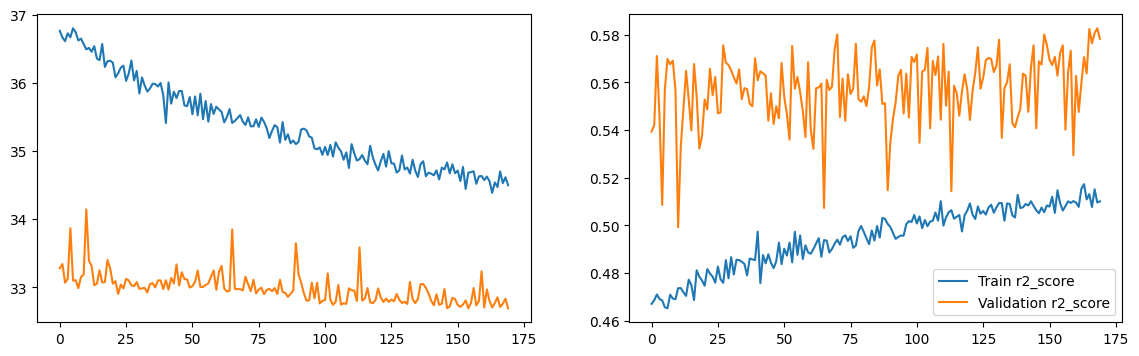

228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
 RMSE: 48.7614, MAE: 33.1894, R2: 0.5783
Fold 2


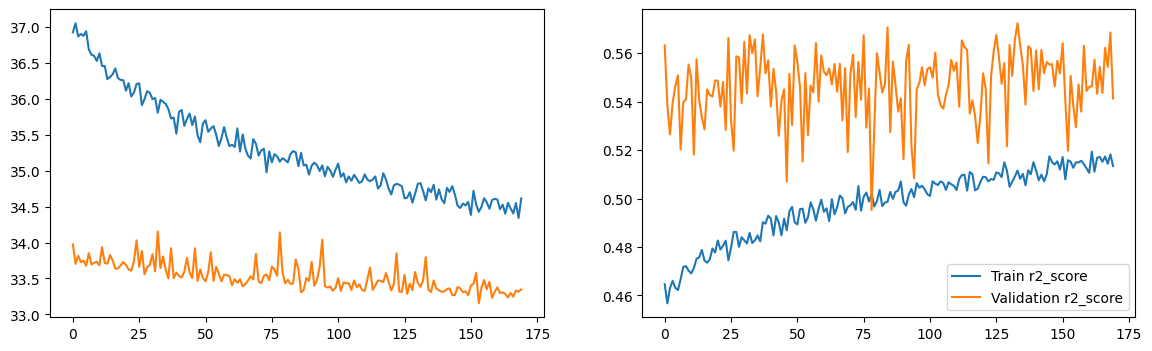

228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
 RMSE: 51.0766, MAE: 33.8427, R2: 0.5413
Fold 3


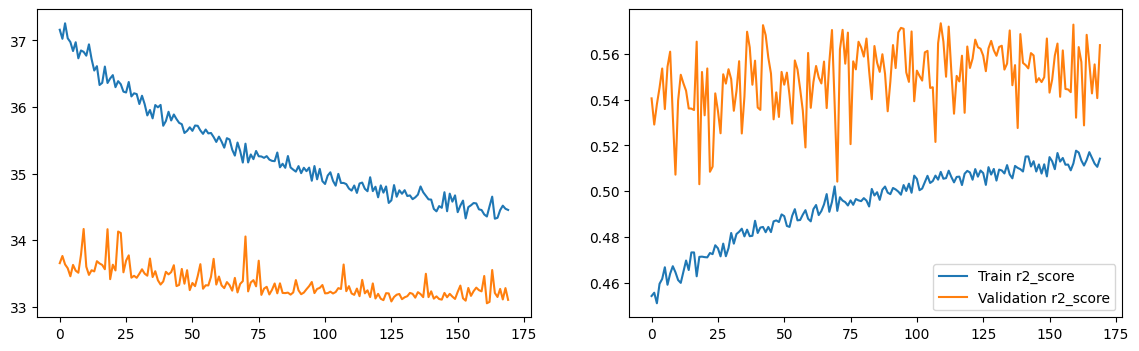

228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 RMSE: 50.3232, MAE: 33.5992, R2: 0.5637
Fold 4


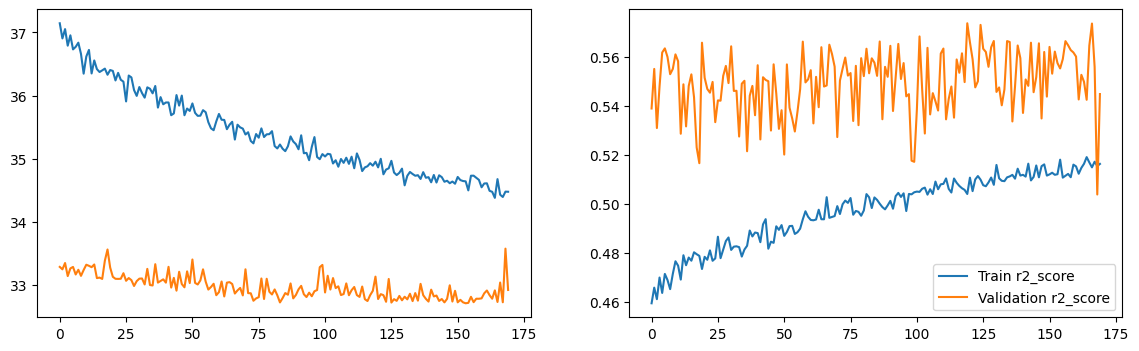

228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
 RMSE: 50.2883, MAE: 33.4169, R2: 0.5447
Fold 5


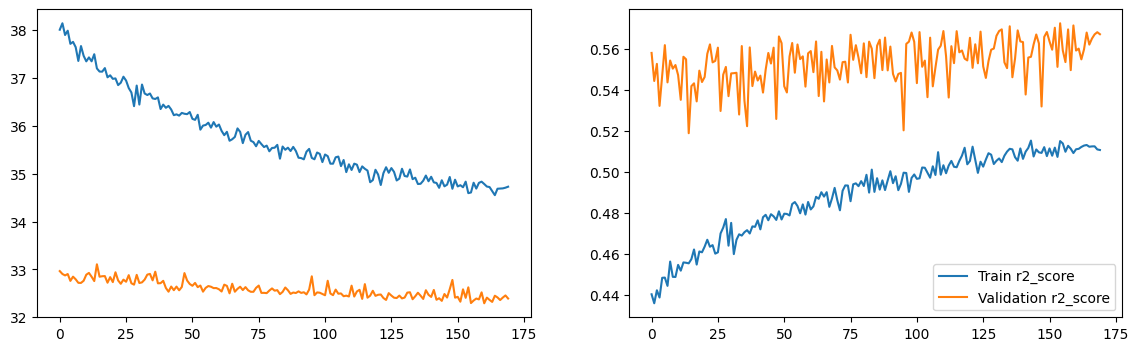

228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
 RMSE: 48.7315, MAE: 32.8869, R2: 0.5673


In [29]:
def create_model():
    Neural_Network = Sequential()

    Neural_Network.add(Input(shape=(X_train.shape[1],)))
    Neural_Network.add(Dense(256, activation='relu'))
    Neural_Network.add(Dropout(0.5))
    Neural_Network.add(Dense(64, activation='relu'))
    Neural_Network.add(Dropout(0.5))
    Neural_Network.add(Dense(1, activation='linear'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    loss_func = tf.keras.losses.Huber()

    mae = tf.keras.metrics.MeanAbsoluteError()
    rmse = tf.keras.metrics.RootMeanSquaredError()
    r2 = tf.keras.metrics.R2Score()

    Neural_Network.compile(optimizer=optimizer, loss=loss_func, metrics=[mae, rmse, r2])

    return Neural_Network


res_Neural_Network = evaluate_model(None, X_train, y_train, 'Neural Network', create_model)

In [30]:
df_results = pd.DataFrame([res_gradient_boost, res_xg_boost, res_lightgbm, res_random_forest, res_Logistic_Regr, res_Neural_Network, res_KNN]).drop(columns=['fold'])
df_results = df_results.reindex(['Model Name', 'rmse', 'mae', 'r2'], axis=1)

In [31]:
df_results.sort_values(by='rmse', ascending=True)

,Model Name,rmse,mae,r2
2,Light_GBM,47.263565,32.963944,0.603490
1,XG Boost,47.897331,33.471163,0.592784
0,Gradient Boost,48.137332,33.708755,0.588715
3,Random Forest,48.220947,33.419297,0.587246
5,Neural Network,49.836216,33.387027,0.559069
6,KNN,51.543515,35.734544,0.528357
4,Logistic Regression,55.967186,38.277595,0.444060


LightGBM was chosen as the final model and performed best among all those selected, with an R² of 0.60, making it the model that best suited the dataset. In addition, the XGBoost and Gradient Boosting models also stood out, presenting statistics very close to those of LightGBM.

LightGBM has several advantages over other models:

* Compared to XGBoost and Gradient Boosting, it trains faster and uses memory more efficiently.

* Unlike Random Forest, which builds independent trees, LightGBM's boosting approach captures patterns more effectively.

* It also outperforms KNN in scalability and is easier to tune than Neural Networks.

* Logistic Regression is more interpretable, but cannot capture complex patterns like LGBM

### Hyperparameter Tuning

Hyperparameter tuning was done using the *GridSearchCV* module, which tests all possible combinations of the selected parameters, also using the K-Fold Cross Validation technique. In an attempt to improve the LGBM, the following hyperparameters were tested:

* 'learning_rate': Controls the contribution of each tree in the final model.
* 'n_estimators': Number of trees (boosting iterations) to be built.
* 'max_depth': Limits the maximum depth of each tree.
* 'num_leaves': Maximum number of leaves in a tree.
* 'min_child_samples': Minimum number of samples required to create a leaf node.
* 'subsample': Fraction of samples to be used to train each tree.

In [33]:
Light_GBM = LGBMRegressor(force_row_wise=True, verbose=1)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.001],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'num_leaves': [5, 10, 20],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=Light_GBM,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 36334, number of used features: 13
[LightGBM] [Info] Start training from score 122.633209


GridSearchCV(cv=5, estimator=LGBMRegressor(force_row_wise=True, verbose=1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.001],
                         'max_depth': [3, 5, 7, 9],
                         'min_child_samples': [10, 20, 30],
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [5, 10, 20], 'subsample': [0.8, 1.0]},
             scoring='r2', verbose=1)

After hyperparameter optimization, the best values ​​were selected and applied to the final model configuration. For this training, the entire training dataset was used, without splitting for validation.

In [34]:
best_parameters = grid_search.best_params_

best_model = LGBMRegressor(**best_parameters, verbose=1)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f" RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

# Saving the model for future predictions
joblib.dump(best_model, "Saved_Models/LGBM_model.pkl")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 36334, number of used features: 13
[LightGBM] [Info] Start training from score 122.633209
 RMSE: 47.5410, MAE: 32.9943, R2: 0.6086


['Saved_Models/LGBM_model.pkl']

The final model achieved a coefficient of determination ($R^2$) of 0.6086, indicating considerable performance. In addition, it obtained a mean absolute error (MAE) of 32.99 and a root mean square error (RMSE) of 47.54, evidencing good predictive capacity in the final test.

## Answering the fourth question

**Assuming an apartment with the following characteristics: What would be your suggested price?**


```
{'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}
```

In [35]:
# Loading the scaler and model
lgbm_model = joblib.load("Saved_Models/LGBM_model.pkl")
scaler = joblib.load("Saved_Models/scaler.pkl")

In [36]:
# Loading test data and deleting unnecessary columns
test_data = pd.read_csv('Data/test_data.csv').drop(columns=['id','nome','host_id','host_name','bairro','ultima_review','reviews_por_mes','calculado_host_listings_count'])

# Encoding the categorical columns
test_data = pd.concat((test_data, pd.get_dummies(test_data['room_type'], dtype=np.uint8),
                       pd.get_dummies(test_data['bairro_group'], dtype=np.uint8)), axis=1).drop(columns=['room_type','bairro_group'])

# Making data in the correct format
test_data = test_data.reindex(columns=dataset.columns, fill_value=0).drop(columns=['price'])
test_data

,latitude,longitude,minimo_noites,numero_de_reviews,disponibilidade_365,Entire home/apt,Private room,Shared room,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,40.75362,-73.98377,1,45,355,1,0,0,0,0,1,0,0


In [37]:
# Transforming the data with the scaler and making the prediction
X_test_data = scaler.transform(test_data.values)
preco_estimado = lgbm_model.predict(X_test_data)[0]

print(f"Estimated rental price: ${preco_estimado:.0f}")

Estimated rental price: $249


For an apartment with the given characteristics, **the estimated rental price would be $249.**

## Conclusions

In this challenge, a predictive model for pricing temporary rentals was developed based on several influential variables. To achieve this, a complete modeling process was carried out, from data exploration and preprocessing to the selection and optimization of the model's hyperparameters.

The results indicate that the final model presented a coefficient of determination $(R^2)$ of **0.6086**, suggesting a considerable level of explainability of the variables on the rental price. In addition, metrics such as the mean absolute error (MAE) of **32.99** and the root mean square error (RMSE) of **47.54** demonstrate solid performance in predicting rental values.

Despite the satisfactory results, some limitations should be considered. The model's performance can be improved by including other variables, such as `nome`, which, as observed in the exploratory analysis (EDA), is correlated with the price. Furthermore, variables related to valuations, which were removed due to the large amount of missing data, could also contribute to improving predictions. Finally, the pricing of temporary rentals for high-value properties should be treated separately, considering the specific characteristics of this segment.